In [1]:
from common import colors, sbarlw

In [2]:
import os
os.chdir(os.path.join('..', '..', '..'))
print(os.getcwd())

/Users/eharkin/Documents/projects/5HTGIF


In [3]:
from __future__ import division

import sys
sys.path.append('./analysis/spk_timing/IA_mod')
sys.path.append('./figs/scripts')

import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

import IAmod
from grr import pltools

In [4]:
Vin = np.empty((10000, 600))
Vin[:1000, :] = 0
Vin[1000:, :] = 60.2

low_IA_mod = IAmod.IAmod(5, 1.2, 4)
hi_IA_mod = IAmod.IAmod(10, 1.2, 4)
ohmic_mod = IAmod.IAmod(0, 1.2, 4)

print 'Running simulations.',
low_IA_sim = IAmod.Simulation(low_IA_mod, low_IA_mod.El, Vin)
print '.',
hi_IA_sim = IAmod.Simulation(hi_IA_mod, hi_IA_mod.El, Vin)
print '.',
ohmic_sim = IAmod.Simulation(ohmic_mod, ohmic_mod.El, Vin)
print('Done!')

Running simulations. . . Done!


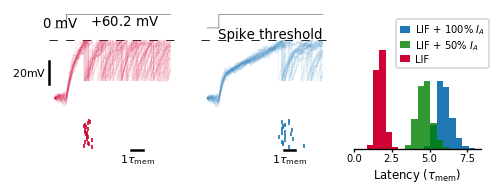

In [31]:
neurons_to_show = 20
hi_IA_color = (0.2, 0.2, 0.9)
low_IA_color = (0.07, 0.07, 0.3)

plt.style.use('./figs/scripts/writeup/publication_figure_style.dms')

IMG_PATH = './figs/ims/defence/'

spec_outer = gs.GridSpec(1, 3, hspace = 0.5, left = 0.05, right = 0.95, top=0.95, bottom=0.2)
spec_low_traces = gs.GridSpecFromSubplotSpec(3, 1, spec_outer[0, 0], height_ratios = [0.2, 1, 0.4])
spec_hi_traces = gs.GridSpecFromSubplotSpec(3, 1, spec_outer[0, 1], height_ratios = [0.2, 1, 0.4])

plt.figure(figsize = (4, 1.5))

low_ax = plt.subplot(spec_low_traces[0, :])
plt.plot(
    ohmic_sim.t_vec,
    Vin[:, 0],
    color = 'gray', lw = 0.5
)
plt.annotate('$0$ mV', (0.5, 2), ha = 'center')
plt.annotate('$+60.2$ mV', (9, 58), ha = 'right', va = 'top')
pltools.hide_border()
pltools.hide_ticks()

low_vtrace_ax = plt.subplot(spec_low_traces[1, :], sharex = low_ax)
plt.axhline(-20, color = 'k', lw = 0.5, ls = '--', dashes = (10, 10))
plt.plot(
    ohmic_sim.t_vec,
    ohmic_sim.V[:, :neurons_to_show],
    color = colors['4AP'], lw = 0.5, alpha = 0.1
)
pltools.add_scalebar(y_units = 'mV', y_size=20, omit_x = True, anchor = (0, 0.3), linewidth=sbarlw)

plt.subplot(spec_low_traces[2, :], sharex = low_ax)
for i in range(neurons_to_show):
    first_spk = 1e-3 * np.min(np.where(ohmic_sim.spks[:, i])[0])
    plt.plot(
        first_spk,
        i,
        '|', color=colors['4AP'], markersize = 2
    )
pltools.add_scalebar(
    x_units = '$\\tau_{{\mathrm{{mem}}}}$', omit_y = True, x_size = 1,
    anchor = (0.8, -0.05), x_label_space = -0.1, linewidth=sbarlw
)


hi_ax = plt.subplot(spec_hi_traces[0, :])
plt.plot(
    hi_IA_sim.t_vec,
    Vin[:, 0],
    color = colors['input'], lw = 0.5
)
pltools.hide_border()
pltools.hide_ticks()

plt.subplot(spec_hi_traces[1, :], sharex = hi_ax, sharey=low_vtrace_ax)
plt.axhline(-20, color = 'k', lw = 0.5, ls = '--', dashes = (10, 10))
plt.plot(
    hi_IA_sim.t_vec,
    hi_IA_sim.V[:, :neurons_to_show],
    color = colors['ser'], lw = 0.5, alpha = 0.1
)
pltools.hide_border('a')
pltools.add_scalebar(omit_x=True, omit_y=True)
plt.annotate('Spike threshold', (10, -19), ha = 'right')

plt.subplot(spec_hi_traces[2, :], sharex = hi_ax)
for i in range(neurons_to_show):
    spk_inds = np.where(hi_IA_sim.spks[:, i])[0]
    if len(spk_inds) < 1:
        continue
    first_spk = 1e-3 * np.min(spk_inds)
    plt.plot(
        first_spk,
        i,
        '|', color=colors['ser'], markersize = 2
    )
pltools.add_scalebar(
    x_units = '$\\tau_{{\mathrm{{mem}}}}$', omit_y = True,
    x_size = 1, anchor = (0.8, -0.05), x_label_space = -0.1,
    linewidth=sbarlw
)

bins = np.linspace(0, 8, 20)
plt.subplot(spec_outer[0, 2])
plt.hist(
    hi_IA_sim.get_spk_latencies()[~np.isnan(hi_IA_sim.get_spk_latencies())] - 1,
    edgecolor = 'none', facecolor = colors['ser'], bins = bins,
    label = 'LIF + 100% $I_A$'
)
plt.hist(
    low_IA_sim.get_spk_latencies()[~np.isnan(low_IA_sim.get_spk_latencies())] - 1,
    edgecolor = 'none', facecolor = 'green', bins=bins, alpha=0.8,
    label = 'LIF + 50% $I_A$'
)
plt.hist(
    ohmic_sim.get_spk_latencies()[~np.isnan(ohmic_sim.get_spk_latencies())] - 1,
    edgecolor='none', facecolor=colors['4AP'], bins=bins, label='LIF'
)
plt.xlim(0, plt.xlim()[1])
plt.ylim(0, plt.ylim()[1] * 1.3)
plt.xlabel('Latency ($\\tau_{{\mathrm{{mem}}}}$)')
pltools.hide_border('ltr')
plt.yticks([])
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))


if IMG_PATH is not None:
    plt.savefig(IMG_PATH + 'IA_jitter_theory.png', dpi = 300)
    plt.savefig(IMG_PATH + 'IA_jitter_theory.svg')

plt.show()